# Nézzük meg, hogy zajlik a kiugró értékek észlelése

In [1]:
import numpy as np

np.random.seed(1)
normál = np.random.normal(loc=0.0, scale=1.0, size=1000)
átlag = np.mean(normál)
medián = np.median(normál)
szórásnégyzet = np.var(normál)

print(f"Átlag: {átlag:.3f} Medián: {medián:.3f} ",
      f"Szórásnégyzet: {szórásnégyzet:.3f}")

Átlag: 0.039 Medián: 0.041  Szórásnégyzet: 0.962


In [2]:
from scipy.stats import pearsonr

kiugró = normál.copy()
kiugró[0] = 50.0

átlag = np.mean(kiugró)
medián = np.median(kiugró)
szórásnégyzet = np.var(kiugró)

print(f"Átlag: {átlag:.3f} Medián: {medián:.3f} ",
      f"Szórásnégyzet: {szórásnégyzet:.3f}")

korr_koef, p_érték = pearsonr(normál, kiugró)
print(f"Pearson-féle korreláció: {korr_koef:.3f} ",
      f"p-érték: {p_érték:.3f}")

Átlag: 0.087 Medián: 0.041  Szórásnégyzet: 3.454
Pearson-féle korreláció: 0.570  p-érték: 0.000


# Vizsgáljunk meg egy egyszerű egyváltozós módszert

In [3]:
import pandas as pd
from sklearn.datasets import load_diabetes

def cukorbetegség_adatok_betöltése():
    cukor = load_diabetes()
    X = pd.DataFrame(cukor.data,
                     columns=cukor.feature_names)
    y = pd.DataFrame(cukor.target, columns=['target'])
    return X, y

X, y = cukorbetegség_adatok_betöltése()

Samples total	442<BR>
Dimensionality	10<BR>
Features	real, -.2 < x < .2<BR>
Targets	integer 25 - 346<BR>

In [4]:
pd.options.display.float_format = '{:.2f}'.format
X.describe()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
count,442.00,442.00,442.00,442.00,442.00,442.00,442.00,442.00,442.00,442.00
mean,-0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,0.00,0.00
std,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05
min,-0.11,-0.04,-0.09,-0.11,-0.13,-0.12,-0.10,-0.08,-0.13,-0.14
25%,-0.04,-0.04,-0.03,-0.04,-0.03,-0.03,-0.04,-0.04,-0.03,-0.03
50%,0.01,-0.04,-0.01,-0.01,-0.00,-0.00,-0.01,-0.00,-0.00,-0.00
75%,0.04,0.05,0.03,0.04,0.03,0.03,0.03,0.03,0.03,0.03
max,0.11,0.05,0.17,0.13,0.15,0.20,0.18,0.19,0.13,0.14


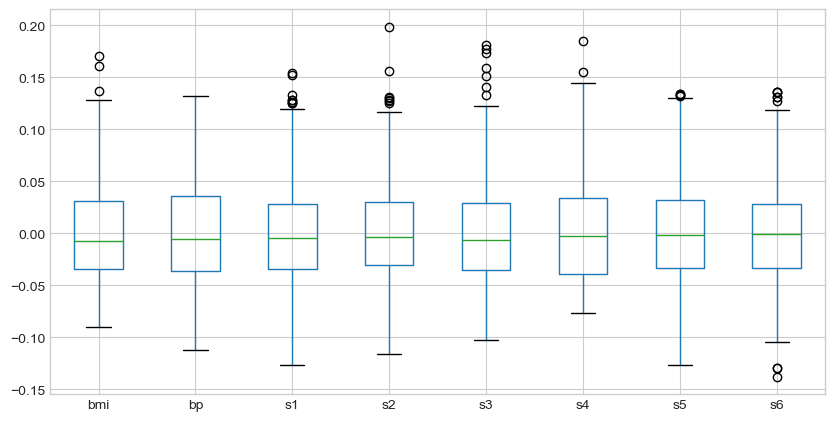

In [5]:
%matplotlib inline
import matplotlib.pyplot as dg
dg.style.use("seaborn-v0_8-whitegrid")

ábra, tengelyek = dg.subplots(nrows=1, ncols=1,
                         figsize=(10, 5))

jellemzők = ["bmi", "bp", "s1", "s2", "s3", "s4", "s5" ,"s6"]
X[jellemzők].boxplot(ax=tengelyek);

## Használjuk ki a Gauss-eloszlást

In [6]:
from sklearn.preprocessing import StandardScaler

Xs = StandardScaler().fit_transform(X[jellemzők])
# A .any(1) metódussal elkerülheted a duplikálást
X[jellemzők][(np.abs(Xs)>3).any(1)].index

Int64Index([58, 123, 216, 230, 256, 260, 261, 269, 322, 336, 367, 441], dtype='int64')

## Korrigáljuk a kiugró értékeket

In [7]:
átlag = X[jellemzők].mean()
szórás = X[jellemzők].std()

# Kizárjuk azokat a sorokat, amelyekben az érték a szórás 3-szorosánál nagyobb távolságra van az átlagtól
csak_érvényes_maszk = (np.abs(X[jellemzők] - átlag) <=
                  (3 * szórás)).all(axis=1)
sorszintű_törlés = X[csak_érvényes_maszk]

print(sorszintű_törlés.shape)

(430, 10)


In [8]:
from scipy.stats.mstats import winsorize

winsorizált = X.copy()
winsorizált[jellemzők] = winsorizált[ jellemzők].apply(
   lambda x: winsorize(x, limits=(0.05, 0.05)))

In [9]:
from sklearn.preprocessing import RobustScaler

ellenálló_újraskálázás = RobustScaler().fit_transform(
    X[jellemzők])

# Dolgozzunk ki egy többváltozós megközelítést

## Használjunk főkomponens-analízist

az első két komponens által magyarázott szórás: 55.2%
az utolsó két komponens által magyarázott szórás: 0.9%


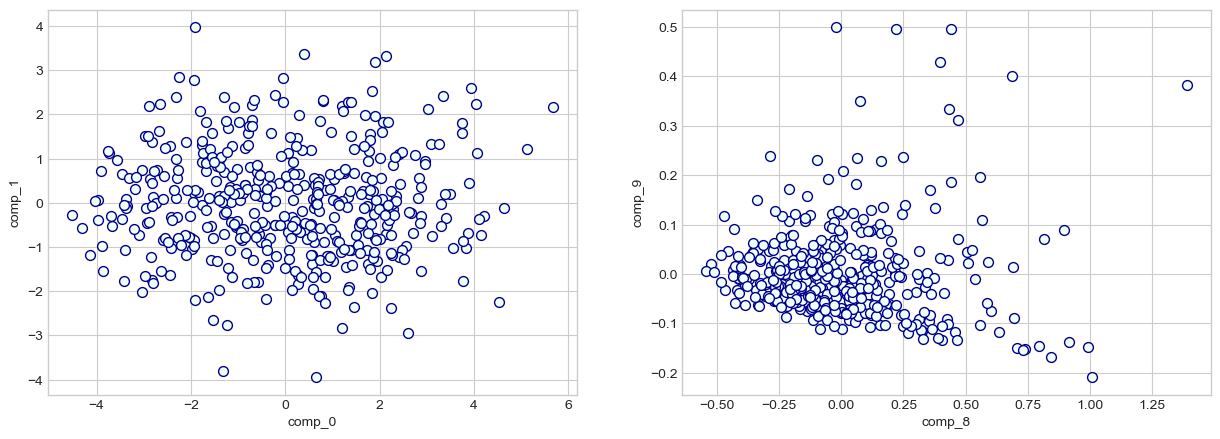

In [10]:
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from pandas.plotting import scatter_matrix
import pandas as pd
import matplotlib.pyplot as dg

pca = PCA()
pca_mat = pca.fit_transform(scale(X))

első_komp = sum(pca.explained_variance_ratio_[:2] * 100)
utolsó_komp = sum(pca.explained_variance_ratio_[-2:] * 100)

print(f"az első két komponens által magyarázott szórás: "
      f"{első_komp:.1f}%")
print(f"az utolsó két komponens által magyarázott szórás: "
      f"{utolsó_komp:.1f}%")
ak_pca = pd.DataFrame(
    pca_mat, columns=[f"comp_{j}" for j in range(10)])

ábra, tengelyek = dg.subplots(nrows=1, ncols=2, figsize=(15, 5))
első_kettő = ak_pca.plot.scatter(
    x="comp_0", y="comp_1", s=50, grid=True,
    c="Azure", edgecolors="DarkBlue", ax=tengelyek[0])
utolsó_kettő = ak_pca.plot.scatter(
    x="comp_8", y="comp_9", s=50, grid=True,
    c="Azure", edgecolors="DarkBlue", ax=tengelyek[1])

dg.show()

In [11]:
kiugró = (pca_mat[:,-1] > 0.3) | (pca_mat[:,-2] > 1.0)
ak_pca[kiugró].index

Int64Index([23, 58, 110, 169, 254, 322, 323, 353, 371, 394], dtype='int64')

## Használjunk klaszteranalízist a kiugró értékek kiszűrésére

In [12]:
from sklearn.cluster import DBSCAN
DB = DBSCAN(eps=2.5, min_samples=25)
DB.fit(pca_mat)

from collections import Counter
print(Counter(DB.labels_))

ak_pca[DB.labels_==-1].index

Counter({0: 414, -1: 28})


Int64Index([ 15,  23,  29,  35,  78, 117, 123, 141, 161, 169, 230, 248, 251,
            261, 276, 321, 322, 323, 336, 349, 352, 353, 367, 376, 394, 405,
            422, 441],
           dtype='int64')

## Automatizáljuk az észlelést izolációs erdőkkel

In [13]:
from sklearn.ensemble import IsolationForest

auto_észlelés = IsolationForest(max_samples=50,
                                 contamination=0.05,
                                 random_state=0)
auto_észlelés.fit(pca_mat)

ierdő = auto_észlelés.predict(pca_mat)
ak_pca[ierdő==-1].index

Int64Index([ 10,  11,  15,  23,  32,  58, 110, 123, 141, 202, 230, 260, 261,
            269, 286, 321, 322, 323, 352, 353, 382, 394, 441],
           dtype='int64')